# Pneumonia Detection From Chest X-Ray

![image](https://i.imgur.com/jZqpV51.png)

## Summary

* [1. Required Libraries](#1)
* [2. Visualizing Data](#2)
* [3. Detecting Pneumonia with CNN](#3)
    - [3.1. Loading Validation Dataset](#3-1)
    - [3.2. Training the CNN](#3-2)
    - [3.3. Evaluating Model Performance](#3-3)

## <span id="1"></span>1. Required Libraries

In [1]:
import os
import math
import random
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.train import Checkpoint
from keras.applications.xception import Xception
from keras.layers import Input, Conv2D, BatchNormalization, Activation, SeparableConv2D, Flatten, Dense, Dropout, MaxPooling2D
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import cv2
import imgaug as aug
import seaborn as sns
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

seed = 99
random.seed(seed)
np.random.seed(seed)
keras.utils.set_random_seed(seed)
aug.seed(seed)

img_width = 299
img_height = 299
batch_size = 16

## <span id="2"></span>2. Visualizing Data

In [2]:
def load_dataset(dataset_type):
    data_dir = Path(f"../input/chest-xray-pneumonia/chest_xray/{dataset_type}/")
    instances = [(file, 0) for file in data_dir.glob("NORMAL/*.jpeg")]
    instances.extend([(file, 1) for file in data_dir.glob("PNEUMONIA/*.jpeg")])
    
    dataset = pd.DataFrame(
        data=instances,
        columns=["image", "label"]
    )

    dataset = dataset.sample(frac=1.).reset_index(drop=True)
    
    return dataset

train_dataset = load_dataset("train")

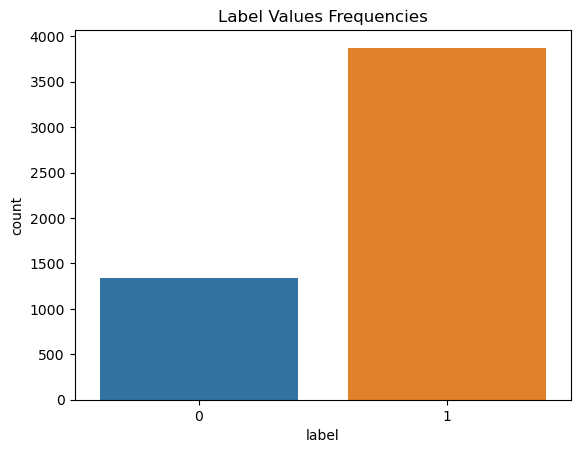

In [3]:
target_counts = train_dataset["label"].value_counts()
plt.title("Label Values Frequencies")
sns.barplot(x=target_counts.index, y=target_counts)
plt.xlabel("label")
plt.ylabel("count")
plt.show()

As we can see, our training dataset is not very big and is highly imbalanced. In scenarios like this, data augmentation plays an important role helping with the generation of new instances of the underbalanced class and helping to prevent model _overfitting_.

In [4]:
train_dataset.shape

(5216, 2)

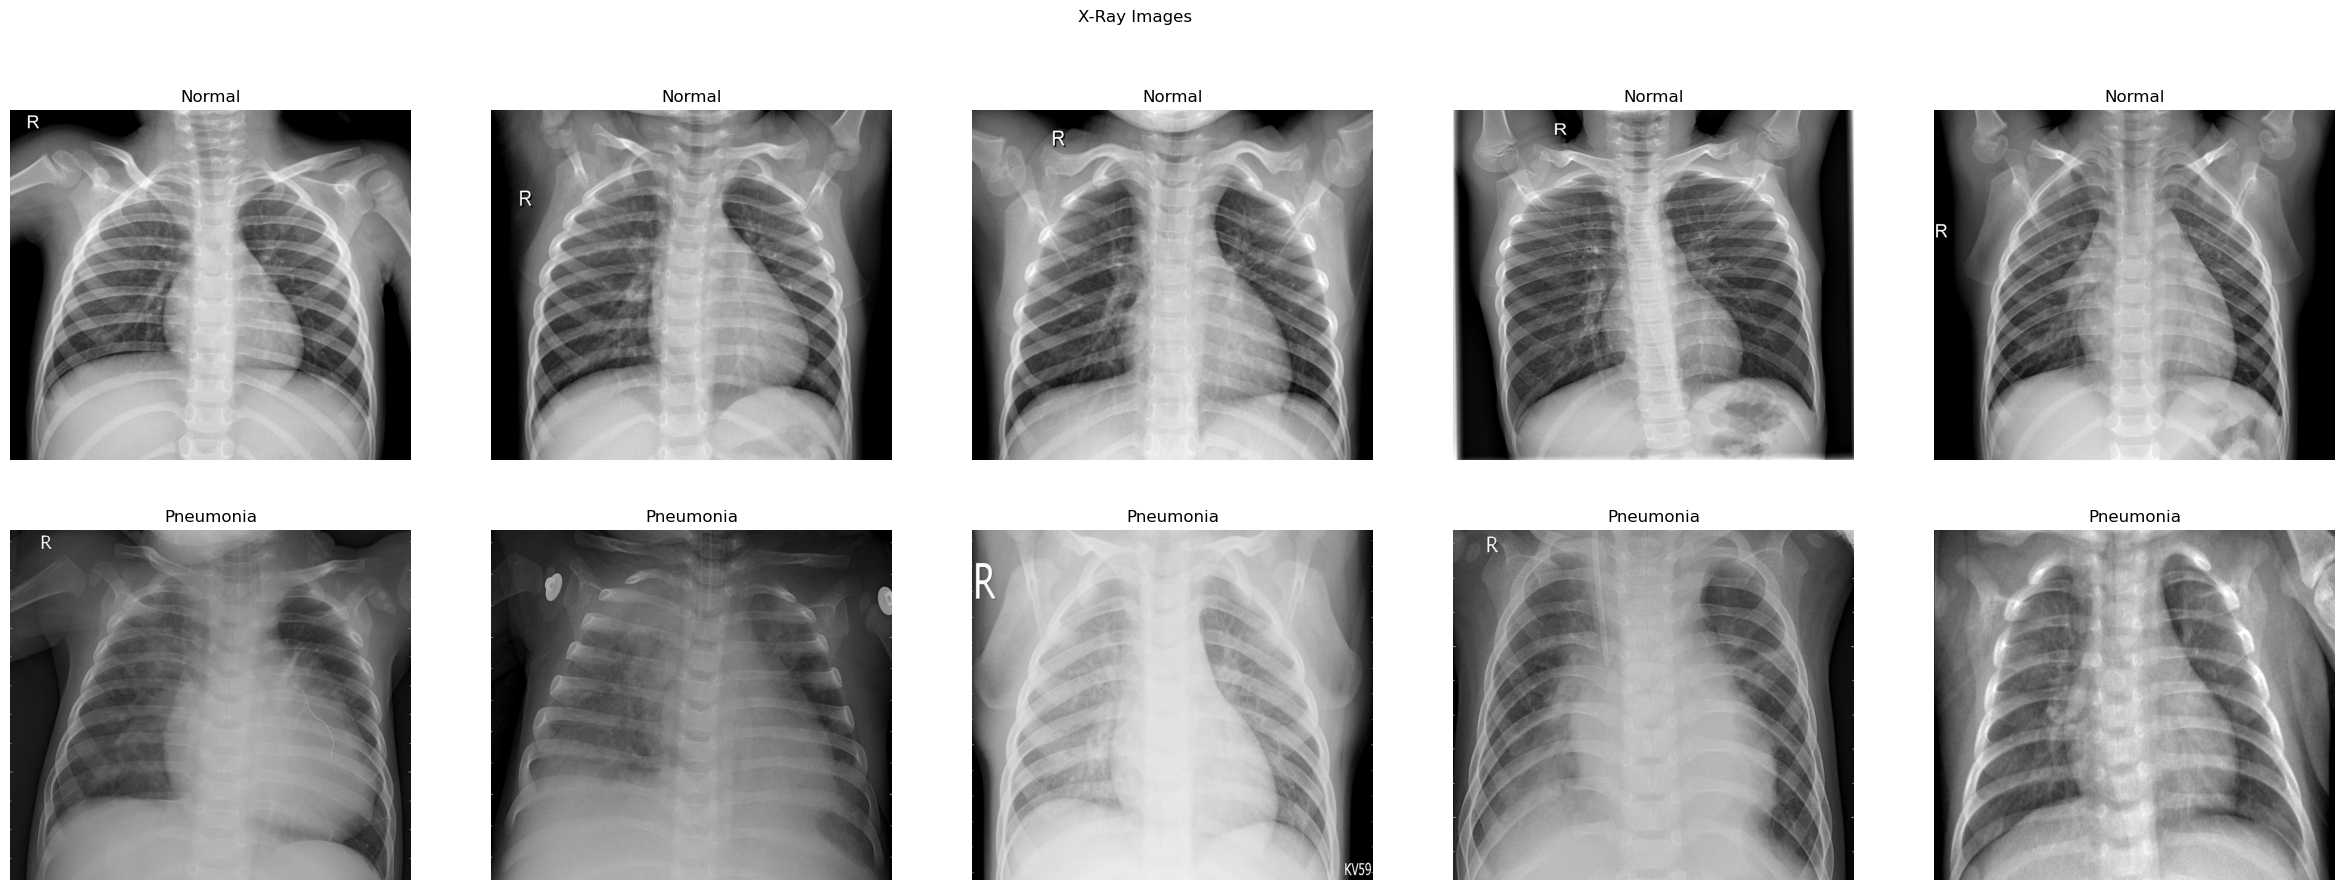

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(30, 10))
fig.suptitle("X-Ray Images")

samples = pd.concat(
    (
        train_dataset.loc[train_dataset["label"] == 0, :].sample(n=5, random_state=seed),
        train_dataset.loc[train_dataset["label"] == 1, :].sample(n=5, random_state=seed)
    ),
    ignore_index=True
).reset_index(drop=True)

for idx, vals in samples.iterrows():
    file, label = vals
    img = plt.imread(file)
    axes[idx // 5, idx % 5].imshow(img, cmap="gray")
    
    if label == 0:
        axes[idx // 5, idx % 5].set_title("Normal")
    else:
        axes[idx // 5, idx % 5].set_title("Pneumonia")
        
    axes[idx // 5, idx % 5].axis("off")
    axes[idx // 5, idx % 5].set_aspect("auto")

fig.show()

## <span id="3"></span>3. Pneumonia Detection with CNN

In this step, we will be using transfer learning to build our final model to sove the problem. Our base network will be the Xception trained with the Imagenet dataset.

In [6]:
def build_model():
    base_model = Xception(include_top=False, weights="imagenet")
    base_model.trainable = False
    
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.7)(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(2, activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = build_model()
model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 1024)              209716224 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                              

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    metrics=[
        "accuracy"
    ],
    loss="binary_crossentropy"
)

### <span id="3-1"></span>3.1. Loading Validation Dataset

In [8]:
val_data = np.zeros((batch_size, img_height, img_width, 3), dtype=np.float32)
val_labels = np.zeros(batch_size, dtype=np.float32)

val_dataset = load_dataset("val")

for idx, (file, label) in val_dataset.reset_index(drop=True).iterrows():
    img = cv2.imread(str(file))
    img = cv2.resize(img, (img_width, img_height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ndim = len(img.shape)
    if ndim < 3:
        img = np.dstack([img] * 3)
        
    img = img.astype(np.float32) / 255.
    
    val_data[idx] = img
    val_labels[idx] = label
        
indices = np.arange(len(val_labels))
np.random.shuffle(indices)
val_data = val_data[indices]
val_labels = to_categorical(val_labels[indices], num_classes=2)

### <span id="3-2"></span>3.2. Training the CNN

In [9]:
seq = aug.augmenters.OneOf([
    aug.augmenters.Fliplr(),
    aug.augmenters.Affine(rotate=20),
    aug.augmenters.Multiply((1.2, 1.5))
])

def data_generator(dataset, batch_size=32, augmentation=False):
    n = len(dataset)
    steps = math.ceil(n / batch_size)
    
    indices = np.arange(n)
    
    data_batch = np.zeros((batch_size, img_width, img_height, 3), dtype=np.float32)
    label_batch = np.zeros(batch_size, dtype=np.float32)
    
    i = 0
    while True:
        count = 0
        
        # shuffle indices before each epoch
        if i == 0:
            np.random.shuffle(indices)
        
        next_batch = indices[i * batch_size : (i + 1) * batch_size]
        for idx in next_batch:
            file = dataset.iloc[idx, :]["image"]
            label = dataset.iloc[idx, :]["label"]
            
            img = cv2.imread(str(file))
            img = cv2.resize(img, (img_width, img_height))
            
            if len(img.shape) < 3:
                img = np.dstack([img] * 3)
            
            img_orig = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_orig = img_orig.astype(np.float32) / 255.
            
            data_batch[count] = img_orig
            label_batch[count] = label
            count += 1
            
            if augmentation:
                if label == 0 and count < batch_size - 2:
                    for _ in range(2):
                        img_aug = seq.augment_image(img)
                        img_aug = cv2.cvtColor(img_aug, cv2.COLOR_BGR2RGB)
                        img_aug = img_aug.astype(np.float32) / 255.
                        data_batch[count] = img_aug
                        label_batch[count] = 0
                        count += 1
                        
            if count >= batch_size:
                break
                
        i += 1
        yield data_batch, to_categorical(label_batch, num_classes=2)
        
        if i >= steps:
            i = 0

def lr_scheduler(epoch, lr):
    if epoch <= 10:
        return lr
    
    return lr * tf.math.exp(-0.001)

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=True),
    keras.callbacks.ModelCheckpoint(filepath='best_model', save_best_only=True, save_weights_only=True),
    keras.callbacks.LearningRateScheduler(lr_scheduler)
]

val_dataset = load_dataset("val")

train_steps = math.ceil(len(train_dataset) / batch_size)
val_steps = math.ceil(len(val_dataset) / batch_size)

model_fit = model.fit(
    x=data_generator(train_dataset, batch_size=batch_size, augmentation=True),
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=(val_data, val_labels),
    callbacks=callbacks,
    class_weight={ 0: 1.0, 1: 0.3 }
)

Epoch 1/50
326/326 [==============================] - 118s 325ms/step - loss: 0.1349 - accuracy: 0.8909 - val_loss: 0.1960 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 2/50
326/326 [==============================] - 105s 324ms/step - loss: 0.0690 - accuracy: 0.9459 - val_loss: 0.1143 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 3/50
326/326 [==============================] - 96s 295ms/step - loss: 0.0558 - accuracy: 0.9542 - val_loss: 0.0937 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 4/50
326/326 [==============================] - 81s 247ms/step - loss: 0.0474 - accuracy: 0.9647 - val_loss: 0.1099 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 5/50
326/326 [==============================] - 93s 285ms/step - loss: 0.0425 - accuracy: 0.9680 - val_loss: 0.0702 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 6/50
326/326 [==============================] - 94s 288ms/step - loss: 0.0359 - accuracy: 0.9728 - val_loss: 0.0525 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 7/50
326/326 [======

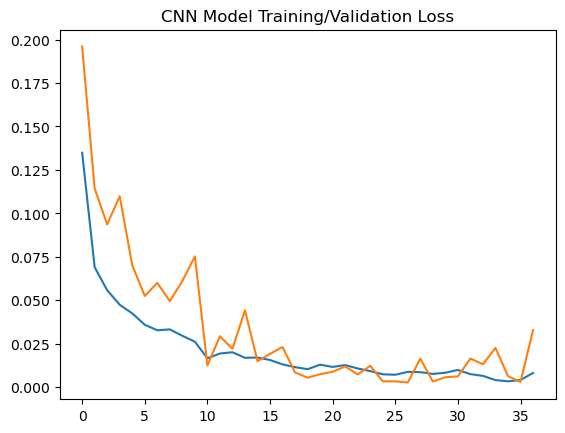

In [10]:
train_loss = model_fit.history["loss"]
val_loss = model_fit.history["val_loss"]

plt.title("CNN Model Training/Validation Loss")
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

In [11]:
test_dataset = load_dataset("test")
n = len(test_dataset)

test_data = np.zeros((n, img_height, img_width, 3), dtype=np.float32)
test_labels = np.zeros(n, dtype=np.float32)

for idx, (file, label) in test_dataset.reset_index(drop=True).iterrows():
    img = cv2.imread(str(file))
    img = cv2.resize(img, (img_width, img_height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ndim = len(img.shape)
    if ndim < 3:
        img = np.dstack([img] * 3)
        
    img = img.astype(np.float32) / 255.
    
    test_data[idx] = img
    test_labels[idx] = label
        
indices = np.arange(len(test_labels))
np.random.shuffle(indices)
test_data = test_data[indices]
test_labels = to_categorical(test_labels[indices], num_classes=2)

### <span id="3-3"></span>3.3. Evaluating Model Performance

In [12]:
preds = model.predict(
    x=test_data
)

y_test = np.argmax(test_labels, axis=1)
y_preds = np.argmax(preds, axis=1)

20/20 [==============================] - 8s 249ms/step


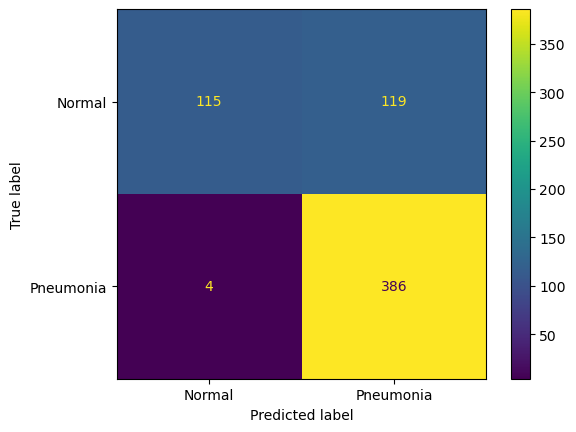

In [13]:
cm = confusion_matrix(y_test, y_preds)
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Pneumonia"]).plot()
plt.show()

The model did a better job classifying the pneumonia cases than the normal ones.

In [14]:
def metrics(y_true, y_pred):
    accuracy = np.round(accuracy_score(y_true, y_pred), 3)
    auc = np.round(roc_auc_score(y_true, y_pred), 3)
    precision = np.round(precision_score(y_true, y_pred), 3)
    recall = np.round(recall_score(y_true, y_pred), 3)
    
    return pd.DataFrame(data=[(accuracy, auc, precision, recall)], columns=[
        "Accuracy",
        "ROC AUC",
        "Precision",
        "Recall"
    ])

metrics(y_test, y_preds)

,Accuracy,ROC AUC,Precision,Recall
0,0.803,0.741,0.764,0.99


From the metrics above, we can see that our model presented a high value for the **recall** metric and an acceptable **precision** as well. In deseases detection applications, the negative impact of false positives is smaller than the false negatives, so it's preferrable higher values for the **recall** instead of **precision**, considering that while one grows, the other decrease.